In [49]:
import pandas as pd

nifty100_df = pd.read_csv('nifty100.csv')
tickers = [ f'NSE:{n}-EQ' for n in nifty100_df.Symbol.tolist()]

In [50]:
from fyers_helper import prepare_data, load_stock_data
import datetime as dt

data_path = "../data"

end_date = dt.datetime.now()
start_date = dt.datetime(2015, 1, 1)

file_paths = prepare_data(tickers, "1D", start_date=start_date, end_date=end_date, path=data_path, overwrite=False)
loaded_data = load_stock_data(file_paths, data_path, "1D")

Loading 1Dmin data: 100%|██████████| 100/100 [00:00<00:00, 106.88it/s]


In [51]:
ohlc_dict = {
    'Open': 'first',
    'Close': 'last'
}

df = pd.concat(loaded_data, names=["Stock", "Date"]).reset_index()
# df = df[df.Date > '2023-01-01'].reset_index(drop=True)
df['Date'] = pd.to_datetime(df['Date'])
# df = df.set_index(['Stock', 'Date']).sort_index()
df = df.groupby('Stock').resample('MS', on='Date').agg(ohlc_dict)

In [52]:
df['entry_price'] = df.groupby('Stock')['Open'].shift(-1)
df['exit_price'] = df.groupby('Stock')['Close'].shift(-1)
df['returns'] = df.groupby('Stock')['Close'].diff()
df['returns_perc'] = df.groupby('Stock')['Close'].pct_change()
df['next_month_returns'] = df.groupby('Stock')['returns'].shift(-1)
df['next_month_returns_perc'] = df.groupby('Stock')['returns_perc'].shift(-1)

In [53]:
from sklearn.linear_model import LinearRegression

def rolling_monthly_slope_fitness(df, window=12):
    df = df.sort_values(['Stock', 'Date'])
    results = []
    for stock, group in df.groupby('Stock'):
        group = group.reset_index(drop=True)
        group['Date_ordinal'] = group['Date'].map(lambda x: x.toordinal())
        for i in range(len(group) - window + 1):
            window_df = group.iloc[i:i+window]
            X = window_df['Date_ordinal'].values.reshape(-1, 1)
            y = window_df['Close'].values
            model = LinearRegression().fit(X, y)
            slope = model.coef_[0]
            fitness = model.score(X, y)  # R² score
            results.append({
                'Stock': stock,
                'Start_Date': window_df['Date'].iloc[0],
                'End_Date': window_df['Date'].iloc[-1],
                f'Slope_{window}m': slope,
                f'Fitness_{window}m': fitness
            })
    return pd.DataFrame(results).set_index(['Stock', 'End_Date'])

# Usage:
slope_12m = rolling_monthly_slope_fitness(df.reset_index(), window=12)
slope_12m['score'] = slope_12m['Slope_12m'] * slope_12m['Fitness_12m']

start_date = slope_12m.index.get_level_values('End_Date')[0]

slope_6m = rolling_monthly_slope_fitness(df.reset_index(), window=6)
slope_6m['score'] = slope_6m['Slope_6m'] * slope_6m['Fitness_6m']
slope_6m = slope_6m[slope_6m.index.get_level_values('End_Date') >= start_date]

slope_3m = rolling_monthly_slope_fitness(df.reset_index(), window=3)
slope_3m['score'] = slope_3m['Slope_3m'] * slope_3m['Fitness_3m']
slope_3m = slope_3m[slope_3m.index.get_level_values('End_Date') >= start_date]

In [54]:
def top_n(_df, n, mask=None):
    dfs = []
    for idx, row in _df.groupby('End_Date'):
        date_mask = []
        if mask is not None:
            date_mask = mask.loc[idx].index.tolist()
            dfs.append(row.loc[date_mask].score.nlargest(n))
        else:
            dfs.append(row.score.nlargest(n))
    return pd.concat(dfs)

top_50 = top_n(slope_12m, 50)
top_30 = top_n(slope_6m, 30, top_50.swaplevel('Stock', 'End_Date').sort_index())
top_10 = top_n(slope_3m, 10, top_30.swaplevel('Stock', 'End_Date').sort_index())
top_10 = top_10.swaplevel('Stock', 'End_Date').sort_index()

In [62]:
from lib import Bank, PositionManager

initial_capital = 1000000
leverage = 1


def backtest(pm: PositionManager):
    data = df[df.index.get_level_values(1) >= start_date].dropna(subset=['entry_price', 'exit_price'])
    for idx, group in data.groupby('Date'):
        date = idx
        selected_stocks = top_10.loc[date].index.tolist()
        capital = pm.bank.balance()
        capital_split = capital / len(selected_stocks)
        for s in selected_stocks:
            d = group.loc[(s, date)]
            pm.new_position(s, date, d['entry_price'], capital_split)
            pm.close_position(s, date, d['exit_price'])

if __name__ == "__main__":
    bank = Bank(initial_capital, number_of_buckets=1)
    pm = PositionManager(bank, leverage=leverage)
    backtest(pm)

In [63]:
from dataclasses import  asdict
trades = pd.DataFrame([asdict(p) for p in pm.closed_positions]).sort_values(['entry_time']).reset_index(drop=True)#.to_csv(f'{root_path}/closed_positions.csv', index=False)

In [64]:
import pandas as pd
from datetime import datetime

# Ensure entry_time and exit_time are datetime
trades['entry_time'] = pd.to_datetime(trades['entry_time'])
trades['exit_time'] = pd.to_datetime(trades['exit_time'])

# Total trades
total_trades = len(trades)

# Win rate
win_trades = (trades['pnl'] > 0).sum()
win_rate = win_trades / total_trades * 100 if total_trades > 0 else 0

# Total profit
total_profit = trades['pnl'].sum() - trades['tax'].sum()

# Total tax
total_tax = trades['tax'].sum()

# CAGR calculation
start = trades['entry_time'].min()
end = trades['exit_time'].max()
years = (end - start).days / 365.25
initial = initial_capital  # initial_capital from your code
final = initial + total_profit
cagr = ((final / initial) ** (1 / years) - 1) * 100 if years > 0 else None

# Active positions
active_position_count = sum([len(p.trades) for p in pm.get_active_positions() if p is not None])

# Period
period = f"{start.strftime('%Y-%m-%d')} to {end.strftime('%Y-%m-%d')}"

# Max holding period
max_holding_period = (trades['exit_time'] - trades['entry_time']).max().days
avg_holding_period = (trades['exit_time'] - trades['entry_time']).mean().days

# Final capital
final_capital = initial + total_profit


# Calculate drawdown
trades['cum_pnl'] = trades['pnl'].cumsum()

trades['cum_max'] = trades['cum_pnl'].cummax()
trades['drawdown'] = trades['cum_pnl'] - trades['cum_max']
max_drawdown = trades['drawdown'].min()
max_drawdown_pct = abs(max_drawdown) / trades['cum_max'].max() * 100 if trades['cum_max'].max() != 0 else 0

number_of_losses = len(trades[trades['pnl'] < 0])
number_of_wins = len(trades[trades['pnl'] > 0])
profit_factor = trades[trades['pnl'] > 0]['pnl'].sum() / abs(trades[trades['pnl'] < 0]['pnl'].sum()) if abs(trades[trades['pnl'] < 0]['pnl'].sum()) > 0 else None

# Tearsheets summary
tearsheet = pd.DataFrame({
    'Metric': [
        'Period',
        'Final capital',
        'Total Trades',
        'Winners',
        'Losers',
        'Profit factor',
        'Active Position Count',
        'Max holding period (days)',
        'Avg holding period (days)',
        'Win Rate (%)',
        'Total Profit',
        'Total Tax',
        'CAGR (%)',
        'Max Drawdown (%)'
    ],
    'Value': [
        period,
        f"{final_capital:.2f}",
        f"{total_trades:,}",
        f"{number_of_wins:,}",
        f"{number_of_losses:,}",
        f"{profit_factor:.2f}" if profit_factor else "N/A",
        f"{active_position_count:,}",
        f"{max_holding_period:,}",
        f"{avg_holding_period:,}",
        f"{win_rate:.2f}",
        f"{total_profit:,.2f}",
        f"{total_tax:.2f}" if total_tax else "N/A",
        f"{cagr:.2f}" if cagr else "N/A",
        f"{max_drawdown_pct:,.2f}"
    ]
})

tearsheet

,Metric,Value
0,Period,2015-12-01 to 2025-07-01
1,Final capital,3898196.75
2,Total Trades,"1,160"
3,Winners,643
4,Losers,517
5,Profit factor,1.43
6,Active Position Count,0
7,Max holding period (days),0
8,Avg holding period (days),0
9,Win Rate (%),55.43


<Axes: title={'center': 'Cumulative PnL vs Exit Time'}, xlabel='exit_time'>

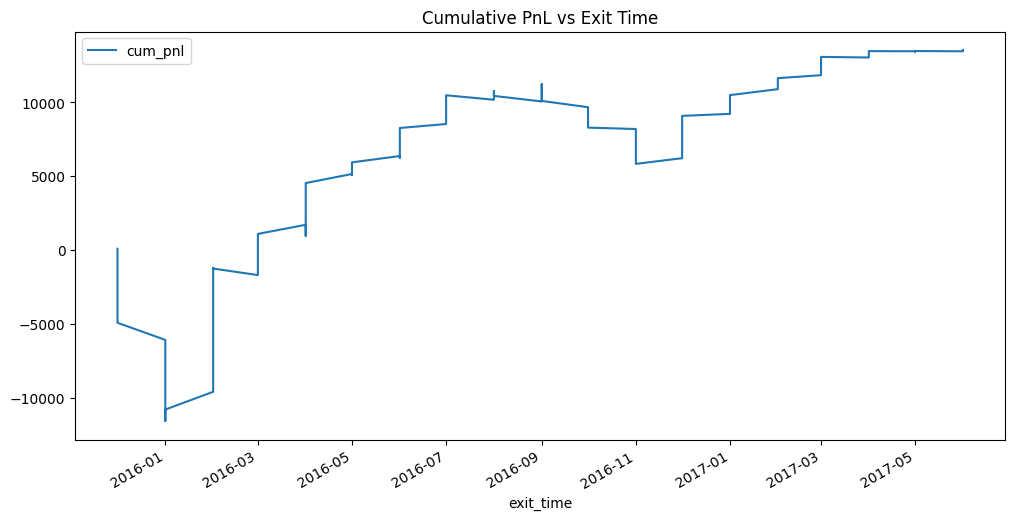

In [59]:
# ...existing code...
trades = trades.sort_values(['exit_time']).reset_index(drop=True)
trades['cum_pnl'] = trades['pnl'].cumsum()
trades.plot(x='exit_time', y='cum_pnl', title='Cumulative PnL vs Exit Time', figsize=(12, 6))